<a href="https://colab.research.google.com/github/poojamahajan0712/S6/blob/master/EVA_S6_Step1_incorrect_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [23]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


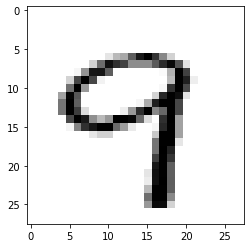

In [24]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

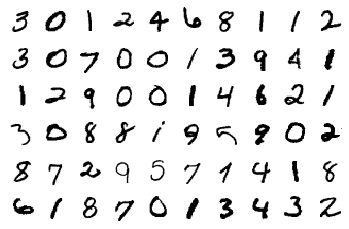

In [25]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26  Rf 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),  #32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    #32
            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF 6 Jout - 2


        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size =10  RF 10 Jout - 2


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8  RF -14 ,Jout - 2

        #self.convblock6 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #   nn.ReLU(),
        #   nn.BatchNorm2d(16),
        #   nn.Dropout(dropout_value)
        #) # output_size = 6 RF - 18  Jout - 2

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
       # x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [27]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
import numpy as np
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_wrong_t=[]
true_wrong_t=[]
image_t=[]



def train(model, device, train_loader, optimizer, epoch,is_L1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    ##Adding code for L1 Regularisation
    if(is_L1==True):
      
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
          reg_loss += l1_crit(param,target=torch.zeros_like(param))

      factor = 0.0005
      loss += factor * reg_loss
      train_losses.append(loss)

    else:
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,epoch):
    model.eval()
    test_loss = 0
    correct = 0

    #pred1 = []
    #true = []
    pred_wrong = []
    true_wrong = []
    image = []


    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            
            preds = (pred.cuda()).cpu().numpy()
            target = (target.cuda()).cpu().numpy()

            preds = np.reshape(preds,(len(preds),1))
            target = np.reshape(target,(len(preds),1))

            data = (data.cuda()).cpu().numpy()


            if(epoch==39):
              for i in range(len(preds)):
                #pred1.append(preds[i])
                #true.append(target[i])

                if(preds[i]!=target[i]):
                    pred_wrong.append(preds[i])
                    true_wrong.append(target[i])
                    image.append(data[i])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

    pred_wrong_t.extend(pred_wrong)
    true_wrong_t.extend(true_wrong)
    image_t.extend(image)

    
    #return(test_acc,test_loss)

# Let's Train and test our model

In [29]:
def train_model(is_L1,is_L2):
  model =  Net().to(device)
  
  if(is_L2==True):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,is_L1)
      test(model, device, test_loader,epoch)
  
  #return(test_acc,test_losses)

#train_model(is_L1=False,is_L2=False)
#a2=train_model(is_L1=True,is_L2=False)
a3=train_model(is_L1=False,is_L2=True)
#a4=train_model(is_L1=True,is_L2=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2740205228328705 Batch_id=468 Accuracy=84.99: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2280, Accuracy: 9427/10000 (94.27%)

EPOCH: 1


Loss=0.1103716716170311 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1269, Accuracy: 9726/10000 (97.26%)

EPOCH: 2


Loss=0.08859547972679138 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9751/10000 (97.51%)

EPOCH: 3


Loss=0.15290673077106476 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9772/10000 (97.72%)

EPOCH: 4


Loss=0.06911900639533997 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1092, Accuracy: 9746/10000 (97.46%)

EPOCH: 5


Loss=0.05497262254357338 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0980, Accuracy: 9794/10000 (97.94%)

EPOCH: 6


Loss=0.09065743535757065 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1192, Accuracy: 9720/10000 (97.20%)

EPOCH: 7


Loss=0.06200559064745903 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9852/10000 (98.52%)

EPOCH: 8


Loss=0.07965084165334702 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Accuracy: 9807/10000 (98.07%)

EPOCH: 9


Loss=0.08207153528928757 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 9760/10000 (97.60%)

EPOCH: 10


Loss=0.07356494665145874 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9807/10000 (98.07%)

EPOCH: 11


Loss=0.07927224040031433 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:11<00:00, 40.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9789/10000 (97.89%)

EPOCH: 12


Loss=0.05060165748000145 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9856/10000 (98.56%)

EPOCH: 13


Loss=0.06542440503835678 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0937, Accuracy: 9783/10000 (97.83%)

EPOCH: 14


Loss=0.09315227717161179 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0950, Accuracy: 9794/10000 (97.94%)

EPOCH: 15


Loss=0.08395632356405258 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:11<00:00, 39.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9813/10000 (98.13%)

EPOCH: 16


Loss=0.047118231654167175 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 9804/10000 (98.04%)

EPOCH: 17


Loss=0.061242494732141495 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9832/10000 (98.32%)

EPOCH: 18


Loss=0.052123840898275375 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0746, Accuracy: 9858/10000 (98.58%)

EPOCH: 19


Loss=0.047157447785139084 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9818/10000 (98.18%)

EPOCH: 20


Loss=0.1154804602265358 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Accuracy: 9840/10000 (98.40%)

EPOCH: 21


Loss=0.09619192034006119 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1081, Accuracy: 9742/10000 (97.42%)

EPOCH: 22


Loss=0.04413847252726555 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 46.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9855/10000 (98.55%)

EPOCH: 23


Loss=0.11095046252012253 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9825/10000 (98.25%)

EPOCH: 24


Loss=0.07262549549341202 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:11<00:00, 39.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9873/10000 (98.73%)

EPOCH: 25


Loss=0.17656254768371582 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 39.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9892/10000 (98.92%)

EPOCH: 26


Loss=0.044552918523550034 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9837/10000 (98.37%)

EPOCH: 27


Loss=0.16316917538642883 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9827/10000 (98.27%)

EPOCH: 28


Loss=0.08576824516057968 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:11<00:00, 43.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0945, Accuracy: 9777/10000 (97.77%)

EPOCH: 29


Loss=0.03668823093175888 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 40.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0904, Accuracy: 9791/10000 (97.91%)

EPOCH: 30


Loss=0.05256245657801628 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0936, Accuracy: 9795/10000 (97.95%)

EPOCH: 31


Loss=0.05536371096968651 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9841/10000 (98.41%)

EPOCH: 32


Loss=0.08328979462385178 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0850, Accuracy: 9804/10000 (98.04%)

EPOCH: 33


Loss=0.10040674358606339 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9819/10000 (98.19%)

EPOCH: 34


Loss=0.08283733576536179 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1035, Accuracy: 9768/10000 (97.68%)

EPOCH: 35


Loss=0.04446247220039368 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 38.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0739, Accuracy: 9844/10000 (98.44%)

EPOCH: 36


Loss=0.07899538427591324 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9734/10000 (97.34%)

EPOCH: 37


Loss=0.0731084793806076 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 38.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9857/10000 (98.57%)

EPOCH: 38


Loss=0.05766144022345543 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 38.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9871/10000 (98.71%)

EPOCH: 39


Loss=0.06022149324417114 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s]



Test set: Average loss: 0.1084, Accuracy: 9758/10000 (97.58%)



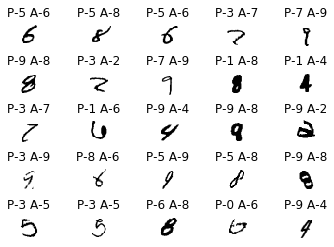

In [31]:
from google.colab import files

figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5,5, index)
    plt.subplots_adjust(hspace=.9)
    plt.axis('off')
    plt.imshow(image_t[index].squeeze(), cmap='gray_r')
    a='P-'+str(int(pred_wrong_t[index]))+" A-"+str(int(true_wrong_t[index]))
    plt.title(a)
  
figure.savefig('L2.png')
files.download("L2.png") 

In [0]:

print(image_t[0].squeeze().shape)

In [0]:
#fig, axs = plt.subplots(2,2,figsize=(15,10))
#axs[0, 0].plot(train_losses)
#axs[0, 0].set_title("Training Loss")
#axs[1, 0].plot(train_acc)
#axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")

In [0]:
'''import random
fig,axes = plt.subplots(figsize=(14, 10), nrows = 5, ncols=5)
for ax in axes.flatten():
        a = random.randint(0,25)
    
        image= image_t[a]
        image = torch.from_numpy(image)
        
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        #ax.set_title(f)
        #ax.axis('off')'''
   

In [0]:
from google.colab import files


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(test_acc[:6], label="without L1 and L2")
ax1.plot(test_acc[6:12], color="green", label="with L1")
ax1.plot(test_acc[12:18], color="red", label="with L2")
ax1.plot(test_acc[18:], color="orange", label="with L1 and L2")
ax1.set_title("Validation Accuracy over 40 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

#extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('Accuracy.png', bbox_inches=extent.expanded(1.1, 1.2))
#files.download("Accuracy.png") 

ax2.plot(test_losses[:6],label="without L1 and L2")
ax2.plot(test_losses[6:12], color="green", label="with L1")
ax2.plot(test_losses[12:18], color="red", label="with L2")
ax2.plot(test_losses[18:], color="orange", label="with L1 and L2")
ax2.set_title("Validation loss over 40 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
#extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('Loss.png', bbox_inches=extent.expanded(1.1, 1.2))
#files.download("Loss.png") 